In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import transforms


from lib.custmized_layer import convLayer, poolLayer, denseLayer
from lib.datasets.spikedataset import SpikeDataset, transform_cifar

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# some handy function to use
from lib.utils import save_model, load_dict, load_model, test_method, get_labels

In [11]:
def plot_stats(stats):
    plt.figure(1)
    plt.semilogy(stats.training.lossLog, label='Training')
    plt.semilogy(stats.testing.lossLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(2)
    plt.plot(stats.training.accuracyLog, label='Training')
    plt.plot(stats.testing.accuracyLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Training
def train(model, model_name, trainloader, testloader, criterion, optimizer, stats, epoch):
    
    for epoch in tqdm(range(epoch)):
        # Reset training stats.
        stats.training.reset()
        tSt = datetime.now()
        model.train()    
        # Training loop.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Gather the training stats.
            _, predicted = torch.max(outputs.data, 1)

            stats.training.correctSamples += torch.sum(predicted == labels).data.item()
            stats.training.numSamples += len(labels)

            # Display training stats.
            # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        # Update training stats.
        stats.training.update()
        # Reset testing stats.
        stats.testing.reset()
        model.eval()    
        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)

            stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
            stats.testing.numSamples += len(labels)

            loss = criterion(outputs, labels)
            stats.testing.lossSum += loss.cpu().data.item()


        # Update stats.
        stats.testing.update()
        if epoch%2==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    print('Finished Training')
    
    test_acc(testloader, model)
    plot_stats(stats)
    save_model(model_name, model)

def test(model, model_name, testloader):
    load_model(model_name, model)
    test_acc(testloader, model)
    
def test_acc(dataloader ,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))
# the learningStat class    


class learningStat():
    '''
    This class collect the learning statistics over the epoch.

    Usage:

    This class is designed to be used with learningStats instance although it can be used separately.

    >>> trainingStat = learningStat()
    '''
    def __init__(self):
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0
        self.minloss = None
        self.maxAccuracy = None
        self.lossLog = []
        self.accuracyLog = []
        self.bestLoss = False
        self.bestAccuracy = False

    def reset(self):
        '''
        Reset the learning staistics. 
        This should usually be done before the start of an epoch so that new statistics counts can be accumulated.

        Usage:

        >>> trainingStat.reset()
        '''
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0

    def loss(self):
        '''
        Returns the average loss calculated from the point the stats was reset.

        Usage:

        >>> loss = trainingStat.loss()
        '''
        if self.numSamples > 0: 
            return self.lossSum/self.numSamples 
        else:   
            return None

    def accuracy(self):
        '''
        Returns the average accuracy calculated from the point the stats was reset.

        Usage:

        >>> accuracy = trainingStat.accuracy()
        '''
        if self.numSamples > 0 and self.correctSamples > 0:
            return self.correctSamples/self.numSamples  
        else:   
            return None

    def update(self):
        '''
        Updates the stats of the current session and resets the measures for next session.

        Usage:

        >>> trainingStat.update()
        '''
        currentLoss = self.loss()
        self.lossLog.append(currentLoss)
        if self.minloss is None:
            self.minloss = currentLoss
        else:
            if currentLoss < self.minloss:
                self.minloss = currentLoss
                self.bestLoss = True
            else:
                self.bestLoss = False
            # self.minloss = self.minloss if self.minloss < currentLoss else currentLoss

        currentAccuracy = self.accuracy()
        self.accuracyLog.append(currentAccuracy)
        if self.maxAccuracy is None:
            self.maxAccuracy = currentAccuracy
        else:
            if currentAccuracy > self.maxAccuracy:
                self.maxAccuracy = currentAccuracy
                self.bestAccuracy = True
            else:
                self.bestAccuracy = False
            # self.maxAccuracy = self.maxAccuracy if self.maxAccuracy > currentAccuracy else currentAccuracy

    def displayString(self):
        loss = self.loss()
        accuracy = self.accuracy()
        minloss = self.minloss
        maxAccuracy = self.maxAccuracy

        if loss is None:    # no stats available
            return None
        elif accuracy is None: 
            if minloss is None: # accuracy and minloss stats is not available
                return 'loss = %-12.5g'%(loss)
            else:   # accuracy is not available but minloss is available
                return 'loss = %-12.5g (min = %-12.5g)'%(loss, minloss)
        else:
            if minloss is None and maxAccuracy is None: # minloss and maxAccuracy is available
                return 'loss = %-12.5g        %-12s   \taccuracy = %-10.5g        %-10s '%(loss, ' ', accuracy, ' ')
            else:   # all stats are available
                return 'loss = %-12.5g (min = %-12.5g)  \taccuracy = %-10.5g (max = %-10.5g)'%(loss, minloss, accuracy, maxAccuracy)

class learningStats():
    '''
    This class provides mechanism to collect learning stats for training and testing, and displaying them efficiently.

    Usage:

    .. code-block:: python
    
        stats = learningStats()

        for epoch in range(100):
            tSt = datetime.now()

            stats.training.reset()
            for i in trainingLoop:
                # other main stuffs
                stats.training.correctSamples += numberOfCorrectClassification
                stats.training.numSamples     += numberOfSamplesProcessed
                stats.training.lossSum        += currentLoss
                stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            stats.training.update()

            stats.testing.reset()
            for i in testingLoop
                # other main stuffs
                stats.testing.correctSamples += numberOfCorrectClassification
                stats.testing.numSamples     += numberOfSamplesProcessed
                stats.testing.lossSum        += currentLoss
                stats.print(epoch, i)
            stats.training.update()

    '''
    def __init__(self):
        self.linesPrinted = 0
        self.training = learningStat()
        self.testing  = learningStat()

    def update(self):
        '''
        Updates the stats for training and testing and resets the measures for next session.

        Usage:

        >>> stats.update()
        '''
        self.training.update()
        self.training.reset()
        self.testing.update()
        self.testing.reset()

    def print(self, epoch, iter=None, timeElapsed=None):
        '''
        Prints the available learning statistics from the current session on the console.
        For Linux systems, prints the data on same terminal space (might not work properly on other systems).

        Arguments:
            * ``epoch``: epoch counter to display (required).
            * ``iter``: iteration counter to display (not required).
            * ``timeElapsed``: runtime information (not required).

        Usage:

        .. code-block:: python

            # prints stats with epoch index provided
            stats.print(epoch) 

            # prints stats with epoch index and iteration index provided
            stats.print(epoch, iter=i) 
            
            # prints stats with epoch index, iteration index and time elapsed information provided
            stats.print(epoch, iter=i, timeElapsed=time) 
        '''
        print('\033[%dA'%(self.linesPrinted))
        
        self.linesPrinted = 1

        epochStr   = 'Epoch : %10d'%(epoch)
        iterStr    = '' if iter is None else '(i = %7d)'%(iter)
        profileStr = '' if timeElapsed is None else ', %12.4f ms elapsed'%(timeElapsed * 1000)

        print(epochStr + iterStr + profileStr)
        print(self.training.displayString())
        self.linesPrinted += 2
        if self.testing.displayString() is not None:
            print(self.testing.displayString())
            self.linesPrinted += 1

    def plot(self, figures=(1, 2), saveFig=False, path=''):
        '''
        Plots the available learning statistics.

        Arguments:
            * ``figures``: Index of figure ID to plot on. Default is figure(1) for loss plot and figure(2) for accuracy plot.
            * ``saveFig``(``bool``): flag to save figure into a file.
            * ``path``: path to save the file. Defaule is ``''``.

        Usage:

        .. code-block:: python

            # plot stats
            stats.plot() 

            # plot stats figures specified
            stats.print(figures=(10, 11)) 
        '''
        plt.figure(figures[0])
        plt.cla()
        if len(self.training.lossLog) > 0:
            plt.semilogy(self.training.lossLog, label='Training')
        if len(self.testing.lossLog) > 0:
            plt.semilogy(self.testing .lossLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        if saveFig is True: 
            plt.savefig(path + 'loss.png')
            # plt.close()

        plt.figure(figures[1])
        plt.cla()
        if len(self.training.accuracyLog) > 0:
            plt.plot(self.training.accuracyLog, label='Training')
        if len(self.testing.accuracyLog) > 0:
            plt.plot(self.testing .accuracyLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend() 
        if saveFig is True: 
            plt.savefig(path + 'accuracy.png')
            # plt.close()

    def save(self, filename=''):
        '''
        Saves the learning satatistics logs.

        Arguments:
            * ``filename``: filename to save the logs. ``accuracy.txt`` and ``loss.txt`` will be appended

        Usage:

        .. code-block:: python

            # save stats
            stats.save() 

            # save stats filename specified
            stats.save(filename='Run101-0.001-') # Run101-0.001-accuracy.txt and Run101-0.001-loss.txt
        '''

        with open(filename + 'loss.txt', 'wt') as loss:
            loss.write('#%11s %11s\r\n'%('Train', 'Test'))
            for i in range(len(self.training.lossLog)): 
                loss.write('%12.6g %12.6g \r\n'%(self.training.lossLog[i], self.testing.lossLog[i]))

        with open(filename + 'accuracy.txt', 'wt') as accuracy:
            accuracy.write('#%11s %11s\r\n'%('Train', 'Test'))
            if self.training.accuracyLog != [None]*len(self.training.accuracyLog):
                for i in range(len(self.training.accuracyLog)): 
                    accuracy.write('%12.6g %12.6g \r\n'%(self.training.accuracyLog[i], self.testing.accuracyLog[i]))

### The structure is deviated from the Cao's paper
1. crop size from 24 to 26, to adapt the vgg16 like
2. use the structure as the SlayerVgg16, for a fair comparison

In [12]:
class Raw_CNN_Cifar(nn.Module):
    def __init__(self):
        super(Raw_CNN_Cifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, padding=1,bias=True)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1, bias=True)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 26, 26) -> (16, 24, 24)
        x = F.max_pool2d(x, 2) #(16, 12, 12)
        x = F.relu(self.conv2(x)) #(32, 12, 12)
        x = F.max_pool2d(x, 2) #(32, 6, 6)
        x = F.relu(self.conv3(x)) #(64, 6, 6)
        x = x.view(-1, 64 * 6 * 6)    #(64*3*3)
        x = self.fc1(x)  #(10*1*1)
        
        return F.log_softmax(x, dim=1)

class Tailored_CNN_Cifar(nn.Module):
    def __init__(self):
        super(Tailored_CNN_Cifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1, bias=False)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 6 * 6) 
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=1)

In [13]:
BATCH_SIZE  = 128

EPOCH = 40

NUM_WORKERS = 2

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
trainset_cifar = CIFAR10(root='./data', train=True, transform=transform_cifar(True), download=True)

trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset_cifar = CIFAR10(root='./data', train=False, transform=transform_cifar(False), download=True)

testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


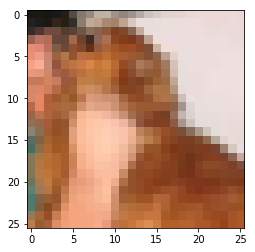

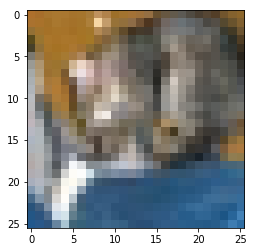

In [6]:
plt.imshow(next(iter(trainloader_cifar))[0][0].permute(1,2,0))
plt.show()

plt.imshow(next(iter(testloader_cifar))[0][0].permute(1,2,0))
plt.show()

  2%|▎         | 1/40 [00:06<04:25,  6.80s/it]


Epoch :          0,    6798.3310 ms elapsed
loss = 0.013879     (min = 0.013879    )  	accuracy = 0.34984    (max = 0.34984   )
loss = 0.011806     (min = 0.011806    )  	accuracy = 0.4586     (max = 0.4586    )


  8%|▊         | 3/40 [00:19<04:03,  6.59s/it]


Epoch :          2,    6388.6950 ms elapsed
loss = 0.010755     (min = 0.010755    )  	accuracy = 0.50938    (max = 0.50938   )
loss = 0.010032     (min = 0.010032    )  	accuracy = 0.5429     (max = 0.5429    )


 12%|█▎        | 5/40 [00:32<03:45,  6.45s/it]


Epoch :          4,    6280.3130 ms elapsed
loss = 0.0095236    (min = 0.0095236   )  	accuracy = 0.57002    (max = 0.57002   )
loss = 0.0089794    (min = 0.0089794   )  	accuracy = 0.599      (max = 0.599     )


 18%|█▊        | 7/40 [00:44<03:31,  6.41s/it]


Epoch :          6,    6472.9360 ms elapsed
loss = 0.008835     (min = 0.008835    )  	accuracy = 0.60344    (max = 0.60344   )
loss = 0.0080872    (min = 0.0080872   )  	accuracy = 0.6456     (max = 0.6456    )


 22%|██▎       | 9/40 [00:57<03:19,  6.43s/it]


Epoch :          8,    6426.1820 ms elapsed
loss = 0.0082487    (min = 0.0082487   )  	accuracy = 0.6303     (max = 0.6303    )
loss = 0.0076825    (min = 0.0076825   )  	accuracy = 0.6659     (max = 0.6659    )


 28%|██▊       | 11/40 [01:10<03:06,  6.44s/it]


Epoch :         10,    6521.2450 ms elapsed
loss = 0.0078571    (min = 0.0078571   )  	accuracy = 0.6484     (max = 0.6484    )
loss = 0.0073185    (min = 0.0073185   )  	accuracy = 0.6759     (max = 0.6759    )


 32%|███▎      | 13/40 [01:23<02:51,  6.34s/it]


Epoch :         12,    6233.2260 ms elapsed
loss = 0.0075209    (min = 0.0075209   )  	accuracy = 0.66498    (max = 0.66498   )
loss = 0.007783     (min = 0.0073185   )  	accuracy = 0.6587     (max = 0.676     )


 38%|███▊      | 15/40 [01:35<02:35,  6.24s/it]


Epoch :         14,    6191.5950 ms elapsed
loss = 0.0072789    (min = 0.0072789   )  	accuracy = 0.673      (max = 0.673     )
loss = 0.0069452    (min = 0.0069452   )  	accuracy = 0.6969     (max = 0.6969    )


 42%|████▎     | 17/40 [01:47<02:23,  6.24s/it]


Epoch :         16,    6353.1490 ms elapsed
loss = 0.0070426    (min = 0.0070426   )  	accuracy = 0.6889     (max = 0.6889    )
loss = 0.0069328    (min = 0.0068062   )  	accuracy = 0.7024     (max = 0.7036    )


 48%|████▊     | 19/40 [02:00<02:11,  6.24s/it]


Epoch :         18,    6267.8920 ms elapsed
loss = 0.0069201    (min = 0.0069201   )  	accuracy = 0.69222    (max = 0.69222   )
loss = 0.0064974    (min = 0.0064974   )  	accuracy = 0.7195     (max = 0.7195    )


 52%|█████▎    | 21/40 [02:13<02:00,  6.33s/it]


Epoch :         20,    6386.6530 ms elapsed
loss = 0.0067672    (min = 0.0067672   )  	accuracy = 0.69856    (max = 0.69856   )
loss = 0.0065106    (min = 0.0064485   )  	accuracy = 0.7177     (max = 0.7199    )


 57%|█████▊    | 23/40 [02:25<01:47,  6.32s/it]


Epoch :         22,    6264.6050 ms elapsed
loss = 0.0066224    (min = 0.0066224   )  	accuracy = 0.70514    (max = 0.70514   )
loss = 0.0066365    (min = 0.0064375   )  	accuracy = 0.7054     (max = 0.7199    )


 62%|██████▎   | 25/40 [02:38<01:35,  6.39s/it]


Epoch :         24,    6480.4790 ms elapsed
loss = 0.0064773    (min = 0.0064773   )  	accuracy = 0.71398    (max = 0.71398   )
loss = 0.0061602    (min = 0.0061602   )  	accuracy = 0.7324     (max = 0.7324    )


 68%|██████▊   | 27/40 [02:50<01:21,  6.24s/it]


Epoch :         26,    6057.1360 ms elapsed
loss = 0.0063963    (min = 0.0063963   )  	accuracy = 0.71584    (max = 0.71726   )
loss = 0.0061276    (min = 0.0061276   )  	accuracy = 0.7334     (max = 0.7334    )


 72%|███████▎  | 29/40 [03:04<01:10,  6.44s/it]


Epoch :         28,    6819.0970 ms elapsed
loss = 0.0063005    (min = 0.0063005   )  	accuracy = 0.71996    (max = 0.71996   )
loss = 0.0060743    (min = 0.0060464   )  	accuracy = 0.7366     (max = 0.7383    )


 78%|███████▊  | 31/40 [03:16<00:57,  6.36s/it]


Epoch :         30,    6172.6690 ms elapsed
loss = 0.0061957    (min = 0.0061957   )  	accuracy = 0.72518    (max = 0.72518   )
loss = 0.0060709    (min = 0.0060464   )  	accuracy = 0.7393     (max = 0.7393    )


 82%|████████▎ | 33/40 [03:29<00:44,  6.34s/it]


Epoch :         32,    6232.8910 ms elapsed
loss = 0.0061473    (min = 0.0061473   )  	accuracy = 0.72806    (max = 0.72806   )
loss = 0.0059082    (min = 0.0059082   )  	accuracy = 0.7448     (max = 0.7448    )


 88%|████████▊ | 35/40 [03:41<00:31,  6.26s/it]


Epoch :         34,    6159.5120 ms elapsed
loss = 0.0060662    (min = 0.0060662   )  	accuracy = 0.73244    (max = 0.73244   )
loss = 0.0059612    (min = 0.0059082   )  	accuracy = 0.7439     (max = 0.7448    )


 92%|█████████▎| 37/40 [03:54<00:18,  6.27s/it]


Epoch :         36,    6329.6230 ms elapsed
loss = 0.0059545    (min = 0.0059545   )  	accuracy = 0.73502    (max = 0.73502   )
loss = 0.006086     (min = 0.0058218   )  	accuracy = 0.7364     (max = 0.7488    )


 98%|█████████▊| 39/40 [04:07<00:06,  6.32s/it]


Epoch :         38,    6317.8340 ms elapsed
loss = 0.0058827    (min = 0.0058827   )  	accuracy = 0.73772    (max = 0.73772   )
loss = 0.0058492    (min = 0.0058218   )  	accuracy = 0.749      (max = 0.749     )


100%|██████████| 40/40 [04:13<00:00,  6.40s/it]

Finished Training


Accuracy of the network: 74 %


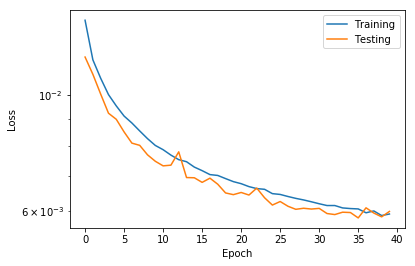

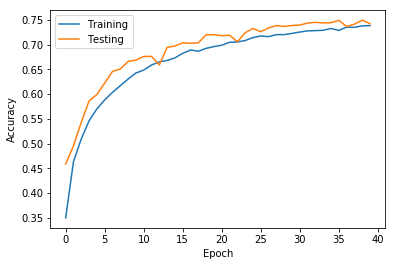

Saving models...


In [8]:
raw_cnn_cifar = Raw_CNN_Cifar().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn_cifar.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn_cifar,'raw_cnn_cifar',
      trainloader_cifar,testloader_cifar,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

The classification accuracy:  0.7421



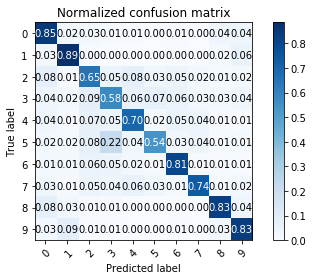

In [15]:
raw_cnn_cifar = Raw_CNN_Cifar().to(device)
load_model('raw_cnn_cifar', raw_cnn_cifar)
labels, preds = get_labels(raw_cnn_cifar, testloader_cifar)
test_method(labels.cpu().numpy(), preds.cpu().numpy())

  2%|▎         | 1/40 [00:06<04:15,  6.55s/it]


Epoch :          0,    6551.8720 ms elapsed
loss = 0.014088     (min = 0.014088    )  	accuracy = 0.33814    (max = 0.33814   )
loss = 0.012223     (min = 0.012223    )  	accuracy = 0.4317     (max = 0.4317    )


  8%|▊         | 3/40 [00:18<03:55,  6.37s/it]


Epoch :          2,    6240.1750 ms elapsed
loss = 0.011284     (min = 0.011284    )  	accuracy = 0.48248    (max = 0.48248   )
loss = 0.01021      (min = 0.01021     )  	accuracy = 0.5397     (max = 0.5397    )


 12%|█▎        | 5/40 [00:31<03:41,  6.33s/it]


Epoch :          4,    6256.3760 ms elapsed
loss = 0.010129     (min = 0.010129    )  	accuracy = 0.5413     (max = 0.5413    )
loss = 0.0095766    (min = 0.0095766   )  	accuracy = 0.5732     (max = 0.5732    )


 18%|█▊        | 7/40 [00:43<03:26,  6.25s/it]


Epoch :          6,    6077.7540 ms elapsed
loss = 0.0094153    (min = 0.0094153   )  	accuracy = 0.57978    (max = 0.57978   )
loss = 0.0088661    (min = 0.0088661   )  	accuracy = 0.6065     (max = 0.6065    )


 22%|██▎       | 9/40 [00:56<03:14,  6.28s/it]


Epoch :          8,    6421.1830 ms elapsed
loss = 0.0089886    (min = 0.0089886   )  	accuracy = 0.59984    (max = 0.59984   )
loss = 0.0082918    (min = 0.0082918   )  	accuracy = 0.6363     (max = 0.6363    )


 28%|██▊       | 11/40 [01:09<03:03,  6.32s/it]


Epoch :         10,    6345.4780 ms elapsed
loss = 0.0085528    (min = 0.0085528   )  	accuracy = 0.6186     (max = 0.6186    )
loss = 0.0079119    (min = 0.0079119   )  	accuracy = 0.6547     (max = 0.6547    )


 32%|███▎      | 13/40 [01:21<02:51,  6.35s/it]


Epoch :         12,    6273.7430 ms elapsed
loss = 0.0082622    (min = 0.0082622   )  	accuracy = 0.63318    (max = 0.63318   )
loss = 0.0076107    (min = 0.0076107   )  	accuracy = 0.6651     (max = 0.6651    )


 38%|███▊      | 15/40 [01:34<02:38,  6.36s/it]


Epoch :         14,    6446.0360 ms elapsed
loss = 0.0079831    (min = 0.0079831   )  	accuracy = 0.64662    (max = 0.64662   )
loss = 0.0076877    (min = 0.0076107   )  	accuracy = 0.6629     (max = 0.6651    )


 42%|████▎     | 17/40 [01:47<02:24,  6.30s/it]


Epoch :         16,    6233.3400 ms elapsed
loss = 0.0077494    (min = 0.0077494   )  	accuracy = 0.65618    (max = 0.65618   )
loss = 0.0075129    (min = 0.0073216   )  	accuracy = 0.6658     (max = 0.6786    )


 48%|████▊     | 19/40 [01:59<02:11,  6.24s/it]


Epoch :         18,    6301.0020 ms elapsed
loss = 0.0075594    (min = 0.0075594   )  	accuracy = 0.66284    (max = 0.66284   )
loss = 0.0071016    (min = 0.0071016   )  	accuracy = 0.6887     (max = 0.6887    )


 52%|█████▎    | 21/40 [02:11<01:57,  6.20s/it]


Epoch :         20,    6156.5340 ms elapsed
loss = 0.0073489    (min = 0.0073489   )  	accuracy = 0.6751     (max = 0.6751    )
loss = 0.007065     (min = 0.0069362   )  	accuracy = 0.6911     (max = 0.6932    )


 57%|█████▊    | 23/40 [02:24<01:45,  6.18s/it]


Epoch :         22,    6209.6480 ms elapsed
loss = 0.0071363    (min = 0.0071363   )  	accuracy = 0.68452    (max = 0.68452   )
loss = 0.0068898    (min = 0.0067752   )  	accuracy = 0.6977     (max = 0.6984    )


 62%|██████▎   | 25/40 [02:36<01:31,  6.13s/it]


Epoch :         24,    6093.9860 ms elapsed
loss = 0.0070036    (min = 0.0070036   )  	accuracy = 0.69154    (max = 0.69154   )
loss = 0.0068061    (min = 0.0066254   )  	accuracy = 0.7074     (max = 0.7132    )


 68%|██████▊   | 27/40 [02:48<01:20,  6.20s/it]


Epoch :         26,    6259.9400 ms elapsed
loss = 0.0068246    (min = 0.0068246   )  	accuracy = 0.69808    (max = 0.69808   )
loss = 0.0064633    (min = 0.0064633   )  	accuracy = 0.7162     (max = 0.7162    )


 72%|███████▎  | 29/40 [03:01<01:08,  6.27s/it]


Epoch :         28,    6389.6300 ms elapsed
loss = 0.0066896    (min = 0.0066896   )  	accuracy = 0.70688    (max = 0.70688   )
loss = 0.0066666    (min = 0.0064633   )  	accuracy = 0.7092     (max = 0.7162    )


 78%|███████▊  | 31/40 [03:14<00:56,  6.31s/it]


Epoch :         30,    6311.2740 ms elapsed
loss = 0.0065471    (min = 0.0065471   )  	accuracy = 0.70898    (max = 0.70898   )
loss = 0.0063487    (min = 0.0063487   )  	accuracy = 0.7242     (max = 0.7242    )


 82%|████████▎ | 33/40 [03:26<00:43,  6.23s/it]


Epoch :         32,    6163.3210 ms elapsed
loss = 0.0064575    (min = 0.0064575   )  	accuracy = 0.71642    (max = 0.71642   )
loss = 0.0063825    (min = 0.0063487   )  	accuracy = 0.724      (max = 0.7242    )


 88%|████████▊ | 35/40 [03:38<00:31,  6.21s/it]


Epoch :         34,    6233.2640 ms elapsed
loss = 0.0064038    (min = 0.0064005   )  	accuracy = 0.71958    (max = 0.71958   )
loss = 0.0061308    (min = 0.0061075   )  	accuracy = 0.7355     (max = 0.7355    )


 92%|█████████▎| 37/40 [03:51<00:18,  6.23s/it]


Epoch :         36,    6211.7670 ms elapsed
loss = 0.006265     (min = 0.006265    )  	accuracy = 0.72398    (max = 0.72398   )
loss = 0.0062798    (min = 0.0061075   )  	accuracy = 0.7217     (max = 0.7355    )


 98%|█████████▊| 39/40 [04:03<00:06,  6.24s/it]


Epoch :         38,    6285.1820 ms elapsed
loss = 0.0062134    (min = 0.0062134   )  	accuracy = 0.72538    (max = 0.72538   )
loss = 0.00596      (min = 0.00596     )  	accuracy = 0.7413     (max = 0.7413    )


100%|██████████| 40/40 [04:10<00:00,  6.46s/it]

Finished Training


Accuracy of the network: 72 %


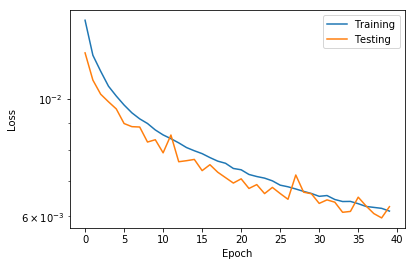

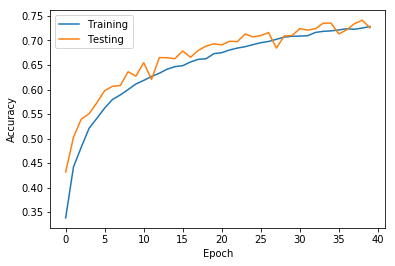

Saving models...


In [8]:
tailored_cnn_cifar = Tailored_CNN_Cifar().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(tailored_cnn_cifar.parameters(), lr=0.001)
raw_stats = learningStats()

train(tailored_cnn_cifar,'tailored_cnn_cifar',
      trainloader_cifar,testloader_cifar,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

The classification accuracy:  0.7258



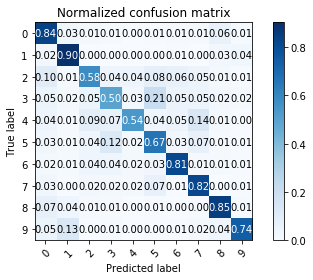

In [16]:
tailored_cnn_cifar = Tailored_CNN_Cifar().to(device)
load_model('tailored_cnn_cifar', tailored_cnn_cifar)
labels, preds = get_labels(tailored_cnn_cifar, testloader_cifar)
test_method(labels.cpu().numpy(), preds.cpu().numpy())

## Now move the weights leart from tailored CNN to our custmized SNN

In [18]:
class custmized_SNN_Cifar(nn.Module):
    
    def __init__(self, thetas, leaks=[0,0,0,0,0,0], V_mins=[0,0,0,0,0,0]):
        super(custmized_SNN_Cifar, self).__init__()
        self.conv1 = convLayer(3, 16, 5, theta=thetas[0], padding=1,leak=leaks[0], V_min=V_mins[0])
        self.pool1 = poolLayer(2, theta=thetas[1], leak=leaks[1], V_min=V_mins[1])
        self.conv2 = convLayer(16, 32, 3, theta=thetas[2], padding=1, leak=leaks[2], V_min=V_mins[2])        
        self.pool2 = poolLayer(2, theta=thetas[3], leak=leaks[3], V_min=V_mins[3])
        self.conv3 = convLayer(32, 64, 3, theta=thetas[4], padding=1, leak=leaks[4], V_min=V_mins[4])
        self.fc1   = denseLayer((6 * 6 * 64), 10, theta=thetas[5], leak=leaks[5], V_min=V_mins[5])
        
    def forward(self, spikeInput):
        spike_conv1 = self.conv1(spikeInput)
        spike_pool1 = self.pool1(spike_conv1)
        spike_conv2 = self.conv2(spike_pool1)
        spike_pool2 = self.pool2(spike_conv2)
        spike_conv3 = self.conv3(spike_pool2)
        spike_for_fc1 = spike_conv3.reshape(-1, 6 * 6 * 64, 1, 1, spike_conv3.shape[-1])
        spikeOut = self.fc1(spike_for_fc1)
        
        return spikeOut

### There are two versions of CIFAR10 datasets we've implemented, since in the paper they had an extra encoding (under sec. 3.2),  which is not super clear how they did it, we try out both versions.

In [9]:
testingSet_C = SpikeDataset(datasetPath = './data', dataset='cifar10', cifar_encoding=False, TimeBins=50,
                    small=False, train=False)

testLoader_C = DataLoader(dataset=testingSet_C, batch_size=32, shuffle=False, num_workers=4)

# the CIFAR dataset using extra encoding method
testingSet_C2 = SpikeDataset(datasetPath = './data', dataset='cifar10', cifar_encoding=True, TimeBins=50,
                    small=False, train=False)

testLoader_C2 = DataLoader(dataset=testingSet_C2, batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### the performance of the randomly initialized SNN on both versions of CIFAR

In [8]:
thetas = [5, 0.99, 1, 0.99, 0.99, 1]

custmized_snn_cifar = custmized_SNN_Cifar(thetas).to(device)

The classification accuracy:  0.1



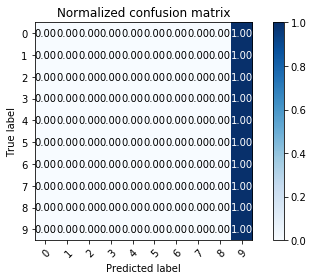

In [19]:
labels, preds = get_labels(custmized_snn_cifar, testLoader_C, snn=True)
test_method(labels.cpu().numpy(), preds.cpu().numpy())

The classification accuracy:  0.1



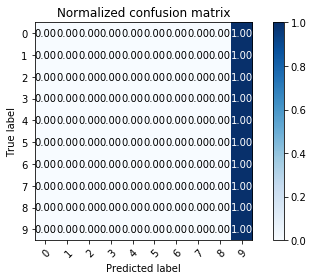

In [20]:
labels, preds = get_labels(custmized_snn_cifar, testLoader_C2, snn=True)
test_method(labels.cpu().numpy(), preds.cpu().numpy())

### Now we move the weights to SNN

In [21]:
tailor_cnn_weights = load_dict("tailored_cnn_cifar")
snn_weights = custmized_snn_cifar.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([16, 3, 5, 5])
Layer conv2.weight
torch.Size([32, 16, 3, 3])
Layer conv3.weight
torch.Size([64, 32, 3, 3])
Layer fc1.weight
torch.Size([10, 2304])


In [22]:
transformed_snn_cifar = custmized_SNN_Cifar(thetas).to(device)
transformed_snn_cifar.load_state_dict(snn_weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

The classification accuracy:  0.1309



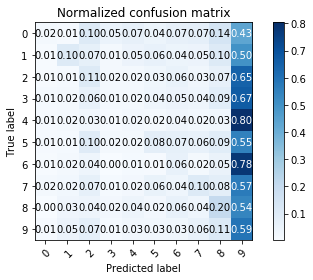

In [23]:
labels, preds = get_labels(transformed_snn_cifar, testLoader_C, snn=True)
test_method(labels.cpu().numpy(), preds.cpu().numpy())

The classification accuracy:  0.1212



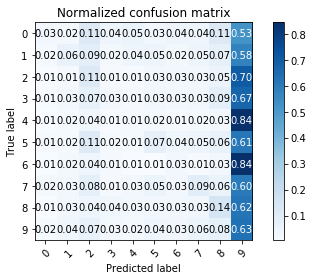

In [24]:
labels, preds = get_labels(transformed_snn_cifar, testLoader_C2, snn=True)
test_method(labels.cpu().numpy(), preds.cpu().numpy())